In [1]:
import sys
import warnings
import datacube
from datacube.storage import masking
from datacube.helpers import ga_pq_fuser
import matplotlib.pyplot as plt


import numpy as np
import seaborn as sns
import pandas as pd
import xarray as xr
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from datacube.helpers import write_geotiff

# Import external functions from dea-notebooks using relative link to Scripts
sys.path.append('./10_Scripts')
import os
import SpatialTools
import gdal
import DEADataHandling
import DEAPlotting

# Connect to datacube database
dc = datacube.Datacube(app='Snow monitoring with Landsat')

In [35]:
import imp
imp.reload(DEADataHandling)

<module 'DEADataHandling' from './10_Scripts/DEADataHandling.py'>

In [1]:
# dc_products = dc.list_products()
# display_columns = ['name', 'description', 'product_type', 'crs', 'resolution', 'spatial_dimensions']
# dc_products[dc_products['name'].str.contains("pq_albers")][display_columns].set_index('name')

In [2]:
lat1, lon1, buffer_m1 = -36.435, 148.29, 8000
# Set range of time to return data from both Landsat and Sentinel 2
#time_range = ('2016-01-01', '2016-12-31')
time_range = ('2017-04-01', '2017-11-30')
resolution = (-25, 25)
landsat_goodquality_prop = 0.0

ndsi_threshold = 0.4
ndvi_threshold = 0.3
ndwi_threshold = 0.15

In [3]:
x, y = geometry.point(lon1, lat1, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query1 = {'x': (x - buffer_m1, x + buffer_m1),
         'y': (y - buffer_m1, y + buffer_m1),    
         'time': time_range,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution}

In [4]:
landsat_ds = DEADataHandling.load_clearlandsat(dc=dc, 
                                               product = 'nbar',
                                               query=query1, 
                                               sensors=['ls5', 'ls8'],
                                               bands_of_interest=['red', 'green', 'blue','nir', 'swir1'],
                                               masked_prop=landsat_goodquality_prop,
                                               mask_pixel_quality=False,
                                               ls7_slc_off=True)

Loading ls5
    Skipping ls5; no valid data for query
Loading ls8
    Loading 31 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [36]:
sensor_pq = DEADataHandling.load_clearlandsat(dc=dc, 
                                               product = 'pq',
                                               query=query1, 
                                               sensors=['ls5','ls7', 'ls8'],
                                               #ands_of_interest=['red', 'green', 'blue','nir', 'swir1'],
                                               masked_prop=landsat_goodquality_prop,
                                               mask_pixel_quality=False,
                                               ls7_slc_off=True)

Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Loading 25 filtered ls7 timesteps
Loading ls8
    Loading 31 filtered ls8 timesteps
Combining and sorting ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [37]:
sensor_pq.pixelquality.flags_definition

{'land_sea': {'bits': 9,
  'values': {'0': 'sea', '1': 'land'},
  'description': 'Land or Sea'},
 'cloud_acca': {'bits': 10,
  'values': {'0': 'cloud', '1': 'no_cloud'},
  'description': 'Cloud (ACCA)'},
 'contiguous': {'bits': 8,
  'values': {'0': False, '1': True},
  'description': 'All bands for this pixel contain non-null values'},
 'cloud_fmask': {'bits': 11,
  'values': {'0': 'cloud', '1': 'no_cloud'},
  'description': 'Cloud (Fmask)'},
 'ga_good_pixel': {'bits': [13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0],
  'values': {'16383': True},
  'description': 'Best Quality Pixel'},
 'nir_saturated': {'bits': 3,
  'values': {'0': True, '1': False},
  'description': 'NIR band is saturated'},
 'red_saturated': {'bits': 2,
  'values': {'0': True, '1': False},
  'description': 'Red band is saturated'},
 'blue_saturated': {'bits': 0,
  'values': {'0': True, '1': False},
  'description': 'Blue band is saturated'},
 'green_saturated': {'bits': 1,
  'values': {'0': True, '1': False},
  'descr

In [53]:
# # Load data
# landsat_ds = dc.load(product='ls8_nbar_albers', group_by='solar_day', **query1)

# # Set all nodata pixels to `NaN`:
# landsat_ds = masking.mask_invalid_data(landsat_ds)
# landsat_ds

<xarray.Dataset>
Dimensions:          (time: 31, x: 641, y: 641)
Coordinates:
  * time             (time) datetime64[ns] 2017-04-04T23:56:25 ... 2017-11-30T23:57:01
  * y                (y) float64 -4.067e+06 -4.067e+06 ... -4.083e+06 -4.083e+06
  * x                (x) float64 1.451e+06 1.451e+06 ... 1.467e+06 1.467e+06
Data variables:
    coastal_aerosol  (time, y, x) float64 123.0 129.0 ... 6.275e+03 6.213e+03
    blue             (time, y, x) float64 76.0 68.0 ... 5.983e+03 5.891e+03
    green            (time, y, x) float64 185.0 168.0 ... 5.978e+03 5.906e+03
    red              (time, y, x) float64 135.0 130.0 ... 6.019e+03 5.945e+03
    nir              (time, y, x) float64 1.587e+03 1.474e+03 ... 6.597e+03
    swir1            (time, y, x) float64 618.0 528.0 ... 3.432e+03 3.404e+03
    swir2            (time, y, x) float64 238.0 218.0 ... 3.05e+03 3.027e+03
Attributes:
    crs:      EPSG:3577

In [8]:
#landsat_ds[['red', 'green', 'blue']].isel(time=1).to_array().plot.imshow(robust=True, figsize=(8, 8))

In [7]:
valid_ds = np.isfinite(landsat_ds.swir1)
# valid_ds.isel(time=0).plot(cmap='Reds_r')

In [8]:
ndsi_ds = (landsat_ds.green - landsat_ds.swir1) / (landsat_ds.green + landsat_ds.swir1)
ndvi_ds = (landsat_ds.nir - landsat_ds.red) / (landsat_ds.nir + landsat_ds.red)
ndwi_ds = (landsat_ds.green - landsat_ds.nir)/(landsat_ds.green + landsat_ds.nir)

In [9]:
snow_ds = ndsi_ds > ndsi_threshold
noveg_ds = ndvi_ds < ndvi_threshold
nowater_ds = ndwi_ds < ndwi_threshold
snow_ds = noveg_ds & snow_ds &nowater_ds

In [31]:
sensor_pq1 = dc.load(product='ls8_pq_albers', fuse_func=ga_pq_fuser, group_by='solar_day', **query1)
sensor_pq1

<xarray.Dataset>
Dimensions:       (time: 31, x: 641, y: 641)
Coordinates:
  * time          (time) datetime64[ns] 2017-04-04T23:56:25 ... 2017-11-30T23:57:01
  * y             (y) float64 -4.067e+06 -4.067e+06 ... -4.083e+06 -4.083e+06
  * x             (x) float64 1.451e+06 1.451e+06 ... 1.467e+06 1.467e+06
Data variables:
    pixelquality  (time, y, x) int16 16383 16383 16383 ... 13311 13311 13311
Attributes:
    crs:      EPSG:3577

In [34]:
sensor_pq1.pixelquality.attrs

OrderedDict([('units', '1'),
             ('nodata', 0),
             ('flags_definition',
              {'land_sea': {'bits': 9,
                'values': {'0': 'sea', '1': 'land'},
                'description': 'Land or Sea'},
               'cloud_acca': {'bits': 10,
                'values': {'0': 'cloud', '1': 'no_cloud'},
                'description': 'Cloud (ACCA)'},
               'contiguous': {'bits': 8,
                'values': {'0': False, '1': True},
                'description': 'All bands for this pixel contain non-null values'},
               'cloud_fmask': {'bits': 11,
                'values': {'0': 'cloud', '1': 'no_cloud'},
                'description': 'Cloud (Fmask)'},
               'ga_good_pixel': {'bits': [13,
                 12,
                 11,
                 10,
                 9,
                 8,
                 7,
                 6,
                 5,
                 4,
                 3,
                 2,
                 1,
     

In [11]:
sensor_pq1.pixelquality.flags_definition

{'land_sea': {'bits': 9,
  'values': {'0': 'sea', '1': 'land'},
  'description': 'Land or Sea'},
 'cloud_acca': {'bits': 10,
  'values': {'0': 'cloud', '1': 'no_cloud'},
  'description': 'Cloud (ACCA)'},
 'contiguous': {'bits': 8,
  'values': {'0': False, '1': True},
  'description': 'All bands for this pixel contain non-null values'},
 'cloud_fmask': {'bits': 11,
  'values': {'0': 'cloud', '1': 'no_cloud'},
  'description': 'Cloud (Fmask)'},
 'ga_good_pixel': {'bits': [13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0],
  'values': {'16383': True},
  'description': 'Best Quality Pixel'},
 'nir_saturated': {'bits': 3,
  'values': {'0': True, '1': False},
  'description': 'NIR band is saturated'},
 'red_saturated': {'bits': 2,
  'values': {'0': True, '1': False},
  'description': 'Red band is saturated'},
 'blue_saturated': {'bits': 0,
  'values': {'0': True, '1': False},
  'description': 'Blue band is saturated'},
 'tir1_saturated': {'bits': 5,
  'values': {'0': True, '1': False},
  'descri

In [57]:
sensor_pq1.pixelquality

<xarray.DataArray 'pixelquality' (time: 31, y: 641, x: 641)>
array([[[16383, 16383, ..., 16383, 16383],
        [16383, 16383, ..., 16383, 16383],
        ...,
        [16383, 16383, ..., 16383, 14335],
        [16383, 16383, ..., 14335, 14335]],

       [[    0,     0, ..., 16383, 16383],
        [    0,     0, ..., 16383, 16383],
        ...,
        [16127, 16127, ..., 16383, 16383],
        [16127, 16127, ..., 16383, 16383]],

       ...,

       [[    0,     0, ..., 16383, 16383],
        [    0,     0, ..., 16383, 16383],
        ...,
        [16383, 16383, ..., 16383, 16383],
        [16383, 16383, ..., 16383, 16383]],

       [[13311, 13311, ..., 13311, 13311],
        [13311, 13311, ..., 13311, 13311],
        ...,
        [13311, 13311, ..., 13311, 13311],
        [13311, 13311, ..., 13311, 13311]]], dtype=int16)
Coordinates:
  * time     (time) datetime64[ns] 2017-04-04T23:56:25 ... 2017-11-30T23:57:01
  * y        (y) float64 -4.067e+06 -4.067e+06 ... -4.083e+06 -4.083e+06


In [19]:
sensor_pq = DEADataHandling.load_clearlandsat(dc=dc, 
                                               product = 'pq',
                                               query=query1, 
                                               sensors=['ls8'],
                                               #bands_of_interest=['red', 'green', 'blue','nir', 'swir1'],
                                               #masked_prop=landsat_goodquality_prop,
                                               mask_pixel_quality=False,
                                               mask_invalid_data=False,
                                               #mask_dict=snow_mask,
                                               ls7_slc_off=True,
                                             satellite_metadata=True)

Loading ls8
    Loading 31 filtered ls8 timesteps
Returning ls8 data


In [20]:
sensor_pq.pixelquality.dtype

dtype('int16')

In [57]:
#sensor_pq.pixelquality.values

In [16]:
# dvf = masking.describe_variable_flags(sensor_pq)
# dvf

In [17]:
# snow_mask = {'cloud_acca':'no_cloud',
#           #'cloud_fmask':'no_cloud',
#           'cloud_shadow_acca':'no_cloud_shadow',
#           #'cloud_shadow_fmask':'no_cloud_shadow',
#          'blue_saturated':False,
#          'green_saturated':False,
#          'red_saturated':False,
#          'nir_saturated':False,
#          'swir1_saturated':False,
#          'swir2_saturated':False,
#          'contiguous':True}
sensor_pq = DEADataHandling.load_clearlandsat(dc=dc, 
                                               product = 'pq',
                                               query=query1, 
                                               sensors=['ls5','ls7', 'ls8'],
                                               #bands_of_interest=['red', 'green', 'blue','nir', 'swir1'],
                                               #masked_prop=landsat_goodquality_prop,
                                               #mask_pixel_quality=False,
                                               #mask_dict=snow_mask,
                                               ls7_slc_off=True)

Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Loading 25 filtered ls7 timesteps
Loading ls8
    Loading 31 filtered ls8 timesteps
Combining and sorting ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [18]:
sensor_pq.pixelquality.dtype

dtype('int64')

In [13]:
good_quality = masking.make_mask(sensor_pq.pixelquality, 
                                 cloud_acca='no_cloud',
                                 #cloud_fmask='no_cloud',
                                 cloud_shadow_acca='no_cloud_shadow',
                                 #cloud_shadow_fmask='no_cloud_shadow',
                                )

NameError: name 'landsat_ds' is not defined

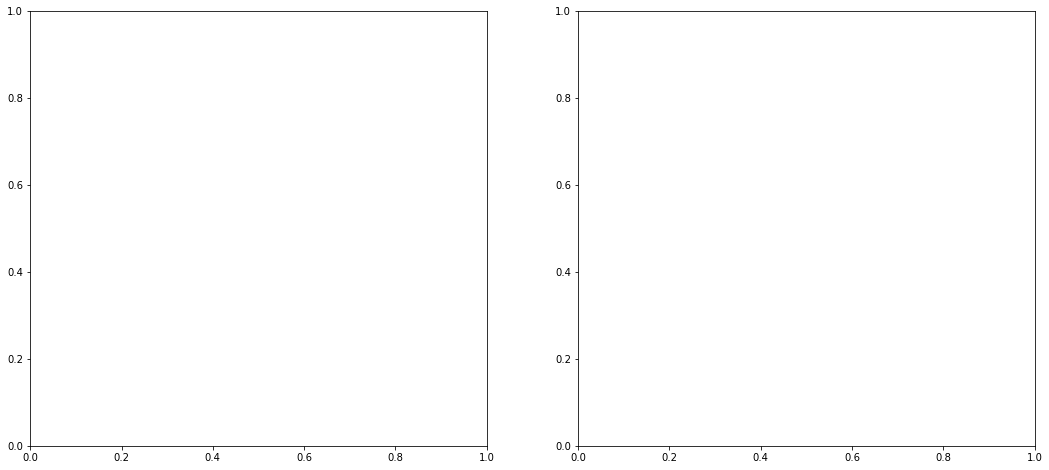

In [12]:
good_quality = masking.make_mask(sensor_pq.pixelquality,
                                 cloud_acca='no_cloud',
                                 #cloud_fmask='no_cloud',
                                 cloud_shadow_acca='no_cloud_shadow',
                                 #cloud_shadow_fmask='no_cloud_shadow',
                                 blue_saturated=False,
                                 green_saturated=False,
                                 red_saturated=False,
                                 nir_saturated=False,
                                 swir1_saturated=False,
                                 swir2_saturated=False,
                                 contiguous=True
                                )
# good_quality.isel(time=1).plot(figsize=(8,8))

import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=2, 
                         figsize = (18, 8)
                        )
i=17
sensor_pq.isel(time=i).plot(ax=axes[0])
landsat_ds[['red', 'green', 'blue']].isel(time=i).to_array().plot.imshow(robust=True, ax=axes[1])

AttributeError: 'QuadMesh' object has no attribute 'set_xlabel'

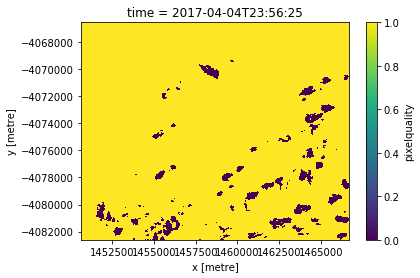

In [66]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("mask.pdf")

c=[0,1]
# fig, axes = plt.subplots(ncols=2, figsize = (18, 8))
#c = list(range(len(good_quality.time)))
        #plt.figure()

for i in c:
    a=good_quality.isel(time=i).plot()#ax=axes[0])
    a.set_xlabel('x meters')
    pdf.savefig()
# for i in c:
#     a=landsat_ds[['red', 'green', 'blue']].isel(time=i).to_array().plot.imshow(robust=True)#,ax=axes[1])
#     pdf.savefig()
plt.close()

In [24]:
c = list(range(len(good_quality.time)))
#c

In [62]:
ds_masked = landsat_ds.where(good_quality)
ds_masked

<xarray.Dataset>
Dimensions:    (time: 31, x: 641, y: 641)
Coordinates:
  * time       (time) datetime64[ns] 2017-04-04T23:56:25 ... 2017-11-30T23:57:01
  * y          (y) float64 -4.067e+06 -4.067e+06 ... -4.083e+06 -4.083e+06
  * x          (x) float64 1.451e+06 1.451e+06 1.451e+06 ... 1.467e+06 1.467e+06
Data variables:
    red        (time, y, x) float64 135.0 130.0 219.0 243.0 ... nan nan nan nan
    green      (time, y, x) float64 185.0 168.0 256.0 288.0 ... nan nan nan nan
    blue       (time, y, x) float64 76.0 68.0 111.0 131.0 ... nan nan nan nan
    nir        (time, y, x) float64 1.587e+03 1.474e+03 2.23e+03 ... nan nan nan
    swir1      (time, y, x) float64 618.0 528.0 811.0 984.0 ... nan nan nan nan
    data_perc  (time, y, x) float64 0.9213 0.9213 0.9213 0.9213 ... nan nan nan
Attributes:
    crs:      EPSG:3577

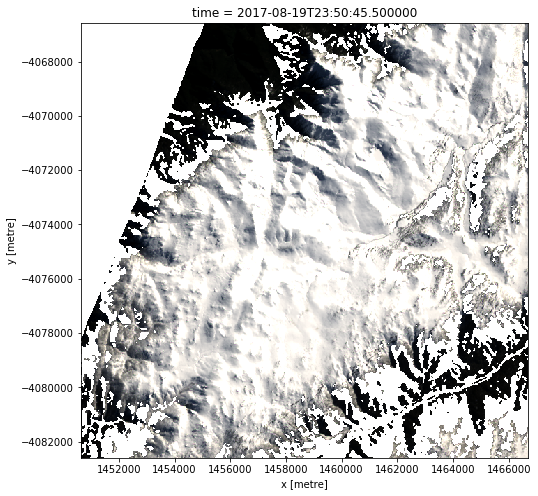

In [63]:
ds_masked[['red', 'green', 'blue']].isel(time=17).to_array().plot.imshow(robust=True, figsize=(8, 8))